##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install simpleitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 14.6 MB/s eta 0:00:00


In [ ]:

import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import fourier_shift, gaussian_filter
from skimage.registration import phase_cross_correlation

In [ ]:
import pandas as pd
import os

##  Traditional Image Registration Benchmark


In [ ]:
# ========== Normalization & Visualization Utilities ==========

def normalize(volume):
    v_min, v_max = np.min(volume), np.max(volume)
    return (volume - v_min) / (v_max - v_min + 1e-8)

def window_ct(volume, level=40, width=400):
    min_val = level - width // 2
    max_val = level + width // 2
    volume = np.clip(volume, min_val, max_val)
    return (volume - min_val) / (max_val - min_val + 1e-8)

def standardize_volume(volume, target_shape=(160, 192, 160), is_ct=False):
    resized = resize(volume, output_shape=target_shape, preserve_range=True, mode='reflect')
    return window_ct(resized) if is_ct else normalize(resized)

def show_slices(fixed, moving, warped, axis=0, slice_idx=None, titles=None):
    if slice_idx is None:
        slice_idx = fixed.shape[axis] // 2
    fixed_slice = np.take(fixed, slice_idx, axis=axis)
    moving_slice = np.take(moving, slice_idx, axis=axis)
    warped_slice = np.take(warped, slice_idx, axis=axis)
    titles = titles or ["Fixed", "Moving", "Warped"]
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip([fixed_slice, moving_slice, warped_slice], titles)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")
    plt.suptitle(f"Slice Index = {slice_idx} (Axis {axis})", fontsize=14)
    plt.tight_layout()
    plt.show()

def animate_slices(volume, axis=0, interval=100, title="Slice"):
    import matplotlib.pyplot as plt
    from IPython.display import display, clear_output
    import time
    num_slices = volume.shape[axis]
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(num_slices):
        clear_output(wait=True)
        slice_ = np.take(volume, i, axis=axis)
        ax.clear()
        ax.imshow(slice_, cmap='gray')
        ax.set_title(f"{title} - Slice {i}/{num_slices-1} (Axis {axis})")
        ax.axis('off')
        display(fig)
        plt.pause(interval / 1000.0)
    plt.close()

def overlay_segmentation(image, mask, alpha=0.3, cmap='Reds'):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.title("Overlay")
    plt.tight_layout()
    plt.show()

# ========== Evaluation ==========

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

def evaluate(fixed_np, registered_np, label=""):
    try:
        fixed_norm = normalize(fixed_np)
        reg_norm = normalize(registered_np)
        ssim_val = ssim(fixed_norm, reg_norm, data_range=1.0)
        mse_val = mean_squared_error(fixed_norm, reg_norm)
        print(f"--- {label} ---")
        print(f"SSIM: {ssim_val:.4f}, MSE: {mse_val:.4f}")
        return {"ssim": ssim_val, "mse": mse_val}
    except Exception as e:
        print(f"⚠️ Evaluation failed for {label}: {e}")
        return {"ssim": None, "mse": None}


def show_registration_results(fixed_np, moving_np, results_dict, is_ct=True):
    fixed_np = window_ct(fixed_np) if is_ct else normalize(fixed_np)
    moving_np = normalize(moving_np)
    results_dict = {k: normalize(v) for k, v in results_dict.items()}

    num_methods = len(results_dict)
    plt.figure(figsize=(3 * (num_methods + 2), 5))

    plt.subplot(1, num_methods + 2, 1)
    plt.imshow(fixed_np, cmap='gray')
    plt.title("Fixed Image")
    plt.axis('off')

    plt.subplot(1, num_methods + 2, 2)
    plt.imshow(moving_np, cmap='gray')
    plt.title("Moving Image")
    plt.axis('off')

    for i, (label, result) in enumerate(results_dict.items()):
        plt.subplot(1, num_methods + 2, i + 3)
        plt.imshow(result, cmap='gray')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


## Visualization

In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

# Create plots folder if not exists
os.makedirs("plots", exist_ok=True)

# Load images
fixed_sitk = sitk.ReadImage("/content/drive/MyDrive/Data/rire/109/ct/patient_109_ct.mhd", sitk.sitkFloat32)
moving_sitk = sitk.ReadImage("/content/drive/MyDrive/Data/rire/109/mr_T1/patient_109_mr_T1.mhd", sitk.sitkFloat32)

# Convert to NumPy
fixed_np_3d = sitk.GetArrayFromImage(fixed_sitk)
moving_np_3d = sitk.GetArrayFromImage(moving_sitk)

# Select center slice
z = fixed_np_3d.shape[0] // 2
fixed_np = fixed_np_3d[z]
moving_np = moving_np_3d[z]

# Normalize functions (from your code)
def normalize(volume):
    v_min, v_max = np.min(volume), np.max(volume)
    return (volume - v_min) / (v_max - v_min + 1e-8)

def window_ct(volume, level=40, width=400):
    min_val = level - width // 2
    max_val = level + width // 2
    volume = np.clip(volume, min_val, max_val)
    return (volume - min_val) / (max_val - min_val + 1e-8)

# Apply preprocessing
fixed_slice = window_ct(fixed_np)  # CT windowing
moving_slice = normalize(moving_np)  # MRI normalization

# Save figures
plt.figure(figsize=(6,6))
plt.imshow(fixed_slice, cmap='gray')
plt.axis('off')
plt.title('Sample CT Slice (Windowed)')
plt.savefig('plots/sample_ct.png', bbox_inches='tight', dpi=300)
plt.close()

plt.figure(figsize=(6,6))
plt.imshow(moving_slice, cmap='gray')
plt.axis('off')
plt.title('Sample MRI Slice (Normalized)')
plt.savefig('plots/sample_mri.png', bbox_inches='tight', dpi=300)
plt.close()

print("Sample images saved to 'plots/sample_ct.png' and 'plots/sample_mri.png'")


✅ Sample images saved to 'plots/sample_ct.png' and 'plots/sample_mri.png'


In [ ]:
# ========== SimpleITK-based Methods ==========
def apply_transform(moving_image, reference_image, transform):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(transform)
    resampler.SetDefaultPixelValue(0)
    return resampler.Execute(moving_image)

def register_mi_rigid(fixed, moving):
    tx = sitk.Euler3DTransform() if fixed.GetDimension() == 3 else sitk.Euler2DTransform()
    init_tx = sitk.CenteredTransformInitializer(fixed, moving, tx, sitk.CenteredTransformInitializerFilter.GEOMETRY)
    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMattesMutualInformation(50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.01)
    reg.SetInterpolator(sitk.sitkLinear)
    reg.SetOptimizerAsRegularStepGradientDescent(2.0, 1e-4, 200)
    reg.SetInitialTransform(init_tx, inPlace=False)
    return reg.Execute(fixed, moving)

def register_mi_affine(fixed, moving):
    tx = sitk.AffineTransform(fixed.GetDimension())
    init_tx = sitk.CenteredTransformInitializer(fixed, moving, tx, sitk.CenteredTransformInitializerFilter.GEOMETRY)
    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMattesMutualInformation(50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.01)
    reg.SetInterpolator(sitk.sitkLinear)
    reg.SetOptimizerAsRegularStepGradientDescent(2.0, 1e-4, 200)
    reg.SetInitialTransform(init_tx, inPlace=False)
    return reg.Execute(fixed, moving)

def register_ncc_rigid(fixed, moving):
    tx = sitk.Euler3DTransform() if fixed.GetDimension() == 3 else sitk.Euler2DTransform()
    init_tx = sitk.CenteredTransformInitializer(fixed, moving, tx, sitk.CenteredTransformInitializerFilter.GEOMETRY)
    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsCorrelation()
    reg.SetInterpolator(sitk.sitkLinear)
    reg.SetOptimizerAsRegularStepGradientDescent(2.0, 1e-4, 200)
    reg.SetInitialTransform(init_tx, inPlace=False)
    return reg.Execute(fixed, moving)


In [ ]:
# ========== NumPy/OpenCV-based Methods ==========


from skimage.transform import resize
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation
import numpy as np

def register_fft(fixed_np, moving_np, upsample_factor=1):
    if fixed_np.shape != moving_np.shape:
        moving_np = resize(moving_np, fixed_np.shape, mode='reflect', preserve_range=True, anti_aliasing=True)

    shift, _, _ = phase_cross_correlation(fixed_np, moving_np, upsample_factor=upsample_factor)
    shifted = fourier_shift(np.fft.fftn(moving_np), shift)
    return np.fft.ifftn(shifted).real



def register_multires_deformable(fixed_np, moving_np, sigma=5.0, iterations=20, alpha=0.05):
    if fixed_np.shape != moving_np.shape:
        moving_np = cv2.resize(moving_np, (fixed_np.shape[1], fixed_np.shape[0]))
    u = np.zeros_like(moving_np)
    v = np.zeros_like(moving_np)
    for _ in range(iterations):
        warped = map_coordinates(moving_np, [np.arange(moving_np.shape[0])[:, None] + u,
                                             np.arange(moving_np.shape[1]) + v], order=1)
        error = fixed_np - warped
        grad_x = gaussian_filter(error, sigma=sigma)
        grad_y = gaussian_filter(error, sigma=sigma)
        u += alpha * grad_x
        v += alpha * grad_y
    coords = np.meshgrid(*[np.arange(s) for s in moving_np.shape], indexing='ij')
    return map_coordinates(moving_np, [coords[0]+u, coords[1]+v], order=1, mode='reflect')


def register_ransac_sift(fixed_np, moving_np, num_keypoints=500, ransac_thresh=5.0):
    fixed_uint8 = cv2.normalize(fixed_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    moving_uint8 = cv2.normalize(moving_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    sift = cv2.SIFT_create(nfeatures=num_keypoints)
    kp1, des1 = sift.detectAndCompute(fixed_uint8, None)
    kp2, des2 = sift.detectAndCompute(moving_uint8, None)

    if des1 is None or des2 is None or len(kp1) < 4 or len(kp2) < 4:
        print("Not enough keypoints.")
        return cv2.resize(moving_np, (fixed_np.shape[1], fixed_np.shape[0]))

    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des2, des1, k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good) < 4:
        print("Not enough good matches.")
        return cv2.resize(moving_np, (fixed_np.shape[1], fixed_np.shape[0]))

    src_pts = np.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    if M is None:
        print("RANSAC failed.")
        return cv2.resize(moving_np, (fixed_np.shape[1], fixed_np.shape[0]))

    warped = cv2.warpAffine(moving_np, M, (fixed_np.shape[1], fixed_np.shape[0]))
    return warped



## Start

In [ ]:
def process_patient(patient_id, base_dir, results_dir):
    ct_path = os.path.join(base_dir, patient_id, "ct", f"patient_{patient_id}_ct.mhd")
    mr_path = os.path.join(base_dir, patient_id, "mr_T1", f"patient_{patient_id}_mr_T1.mhd")


    if not os.path.exists(ct_path) or not os.path.exists(mr_path):
        print(f"Missing data for patient {patient_id}")
        return None

    # Load images
    fixed_sitk = sitk.ReadImage(ct_path, sitk.sitkFloat32)
    moving_sitk = sitk.ReadImage(mr_path, sitk.sitkFloat32)

    # Extract center slice for 2D registration
    fixed_np_3d = sitk.GetArrayFromImage(fixed_sitk)
    moving_np_3d = sitk.GetArrayFromImage(moving_sitk)
    z = fixed_np_3d.shape[0] // 2
    fixed_np = fixed_np_3d[z]
    moving_np = moving_np_3d[z]

    # Apply traditional methods
    tx_mi_rigid = register_mi_rigid(fixed_sitk, moving_sitk)
    tx_mi_affine = register_mi_affine(fixed_sitk, moving_sitk)
    tx_ncc_rigid = register_ncc_rigid(fixed_sitk, moving_sitk)

    reg_mi_rigid = sitk.GetArrayFromImage(apply_transform(moving_sitk, fixed_sitk, tx_mi_rigid))[z]
    reg_mi_affine = sitk.GetArrayFromImage(apply_transform(moving_sitk, fixed_sitk, tx_mi_affine))[z]
    reg_ncc_rigid = sitk.GetArrayFromImage(apply_transform(moving_sitk, fixed_sitk, tx_ncc_rigid))[z]

    # Tune additional methods
    reg_fft = tune_fft(fixed_np, moving_np)
    reg_deform = tune_deformable(fixed_np, moving_np)
    reg_ransac = tune_ransac(fixed_np, moving_np)

    results = {
        "MI-Rigid": reg_mi_rigid,
        "MI-Affine": reg_mi_affine,
        "NCC-Rigid": reg_ncc_rigid,
        "FFT": reg_fft,
        "Deformable": reg_deform,
        "RANSAC": reg_ransac
    }

    # Evaluation
    metrics = {}
    for k, v in results.items():
        score = evaluate(fixed_np, v, k)
        metrics[f"{k}.ssim"] = score["ssim"]
        metrics[f"{k}.mse"] = score["mse"]

    # Visualization
    vis_path = os.path.join(results_dir, "visuals", f"{patient_id}_results.png")
    show_registration_results(fixed_np, moving_np, results, is_ct=True)
    plt.savefig(vis_path)
    plt.close()

    return metrics


# ---------- Run on Entire Dataset ----------
def run_rire_evaluation():
    patient_ids = [f.split('_')[1] for f in os.listdir(CT_DIR) if f.endswith(".mhd")]
    patient_ids = sorted(set(patient_ids))
    print("Running on patients:", patient_ids)

    all_metrics = []
    for pid in patient_ids:
        print(f"➡️ Processing patient {pid}")
        result = process_patient(pid)
        if result:
            all_metrics.append(result)

    df = pd.DataFrame(all_metrics)
    csv_path = os.path.join(RESULTS_DIR, "metrics.csv")
    df.to_csv(csv_path, index=False)
    print("Saved metrics to", csv_path)
    return df


🔍 Processing patient 02
--- FFT (up=1) ---
SSIM: 0.3895, MSE: 0.0727
--- FFT (up=5) ---
SSIM: 0.3895, MSE: 0.0727
--- FFT (up=10) ---
SSIM: 0.3900, MSE: 0.0729
--- Deformable (α=0.5) ---
SSIM: 0.3367, MSE: 0.0829
--- Deformable (α=1.0) ---
SSIM: 0.4753, MSE: 0.0489
--- Deformable (α=2.0) ---
SSIM: 0.4507, MSE: 0.0521
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.6087, MSE: 0.0206
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.6087, MSE: 0.0206
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.6087, MSE: 0.0206
--- MI-Rigid ---
SSIM: 0.5670, MSE: 0.0216
--- MI-Affine ---
SSIM: 0.5432, MSE: 0.0250
--- NCC-Rigid ---
SSIM: 0.5948, MSE: 0.0152
--- FFT ---
SSIM: 0.3900, MSE: 0.0729
--- Deformable ---
SSIM: 0.4753, MSE: 0.0489
--- RANSAC ---
SSIM: 0.6087, MSE: 0.0206


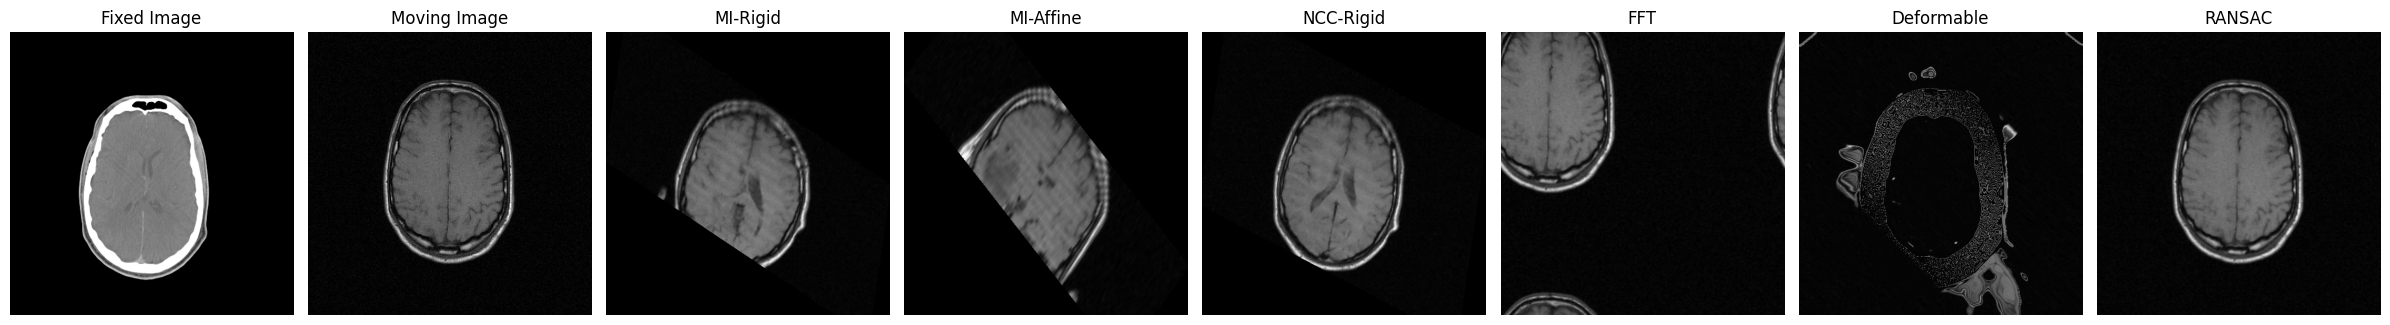

🔍 Processing patient 03
--- FFT (up=1) ---
SSIM: 0.5073, MSE: 0.0437
--- FFT (up=5) ---
SSIM: 0.5073, MSE: 0.0437
--- FFT (up=10) ---
SSIM: 0.5070, MSE: 0.0437
--- Deformable (α=0.5) ---
SSIM: 0.5022, MSE: 0.0420
--- Deformable (α=1.0) ---
SSIM: 0.5528, MSE: 0.0291
--- Deformable (α=2.0) ---
SSIM: 0.5402, MSE: 0.0314
--- RANSAC (kp=100) ---
SSIM: 0.5071, MSE: 0.0259
--- RANSAC (kp=250) ---
SSIM: 0.5071, MSE: 0.0259
--- RANSAC (kp=500) ---
SSIM: 0.5071, MSE: 0.0259
--- MI-Rigid ---
SSIM: 0.6210, MSE: 0.0171
--- MI-Affine ---
SSIM: 0.6174, MSE: 0.0127
--- NCC-Rigid ---
SSIM: 0.6202, MSE: 0.0141
--- FFT ---
SSIM: 0.5073, MSE: 0.0437
--- Deformable ---
SSIM: 0.5528, MSE: 0.0291
--- RANSAC ---
SSIM: 0.5071, MSE: 0.0259


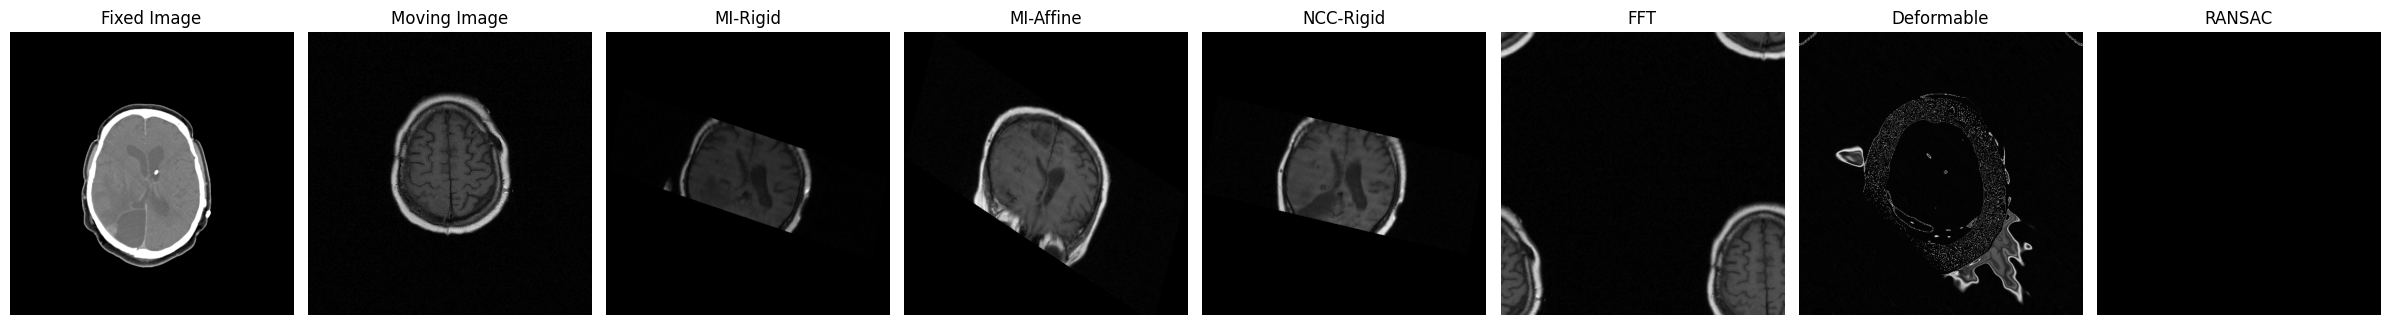

🔍 Processing patient 04
--- FFT (up=1) ---
SSIM: 0.6394, MSE: 0.0140
--- FFT (up=5) ---
SSIM: 0.6432, MSE: 0.0139
--- FFT (up=10) ---
SSIM: 0.6363, MSE: 0.0139
--- Deformable (α=0.5) ---
SSIM: 0.4681, MSE: 0.0580
--- Deformable (α=1.0) ---
SSIM: 0.5111, MSE: 0.0409
--- Deformable (α=2.0) ---
SSIM: 0.5030, MSE: 0.0444
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.6213, MSE: 0.0199
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.6213, MSE: 0.0199
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.6213, MSE: 0.0199
--- MI-Rigid ---
SSIM: 0.6179, MSE: 0.0146
--- MI-Affine ---
SSIM: 0.5282, MSE: 0.0224
--- NCC-Rigid ---
SSIM: 0.5526, MSE: 0.0224
--- FFT ---
SSIM: 0.6432, MSE: 0.0139
--- Deformable ---
SSIM: 0.5111, MSE: 0.0409
--- RANSAC ---
SSIM: 0.6213, MSE: 0.0199


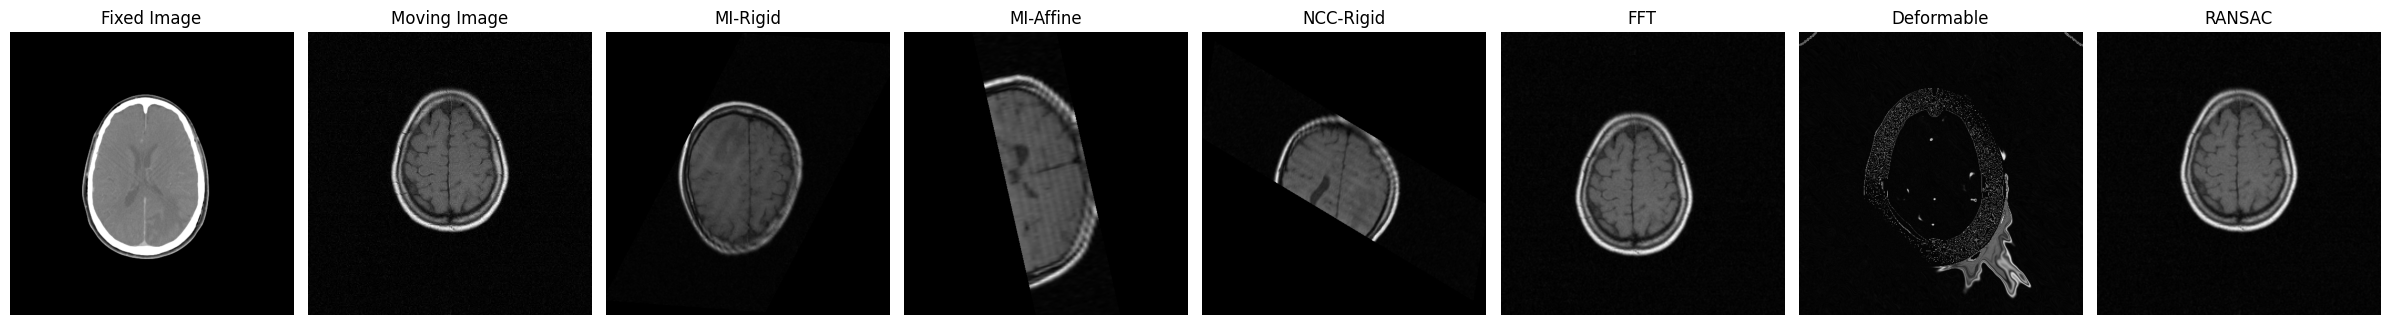

🔍 Processing patient 05
--- FFT (up=1) ---
SSIM: 0.5143, MSE: 0.0624
--- FFT (up=5) ---
SSIM: 0.5143, MSE: 0.0624
--- FFT (up=10) ---
SSIM: 0.5157, MSE: 0.0624
--- Deformable (α=0.5) ---
SSIM: 0.4977, MSE: 0.0624
--- Deformable (α=1.0) ---
SSIM: 0.6142, MSE: 0.0407
--- Deformable (α=2.0) ---
SSIM: 0.5542, MSE: 0.0473
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.7290, MSE: 0.0219
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.7290, MSE: 0.0219
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.7290, MSE: 0.0219
--- MI-Rigid ---
SSIM: 0.5791, MSE: 0.0237
--- MI-Affine ---
SSIM: 0.7207, MSE: 0.0164
--- NCC-Rigid ---
SSIM: 0.6063, MSE: 0.0189
--- FFT ---
SSIM: 0.5157, MSE: 0.0624
--- Deformable ---
SSIM: 0.6142, MSE: 0.0407
--- RANSAC ---
SSIM: 0.7290, MSE: 0.0219


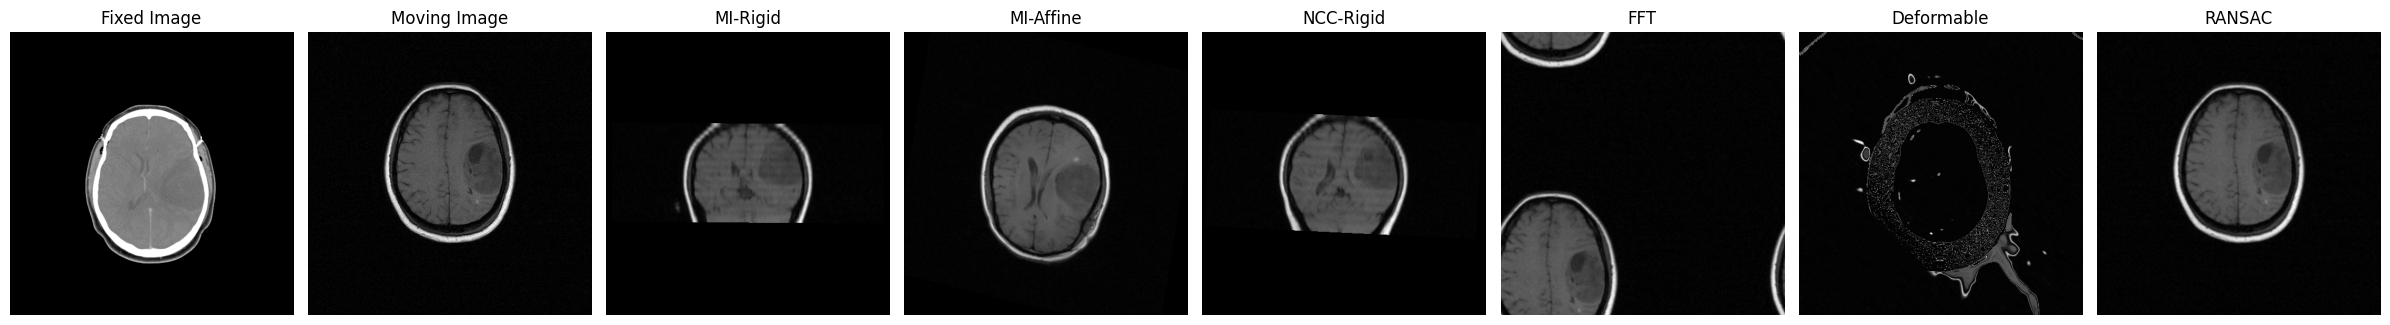

🔍 Processing patient 06
--- FFT (up=1) ---
SSIM: 0.5005, MSE: 0.0613
--- FFT (up=5) ---
SSIM: 0.5005, MSE: 0.0613
--- FFT (up=10) ---
SSIM: 0.5002, MSE: 0.0613
--- Deformable (α=0.5) ---
SSIM: 0.4963, MSE: 0.0591
--- Deformable (α=1.0) ---
SSIM: 0.5816, MSE: 0.0402
--- Deformable (α=2.0) ---
SSIM: 0.5003, MSE: 0.0476
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.7175, MSE: 0.0174
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.7175, MSE: 0.0174
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.7175, MSE: 0.0174
--- MI-Rigid ---
SSIM: 0.5801, MSE: 0.0194
--- MI-Affine ---
SSIM: 0.6020, MSE: 0.0190
--- NCC-Rigid ---
SSIM: 0.6343, MSE: 0.0169
--- FFT ---
SSIM: 0.5005, MSE: 0.0613
--- Deformable ---
SSIM: 0.5816, MSE: 0.0402
--- RANSAC ---
SSIM: 0.7175, MSE: 0.0174


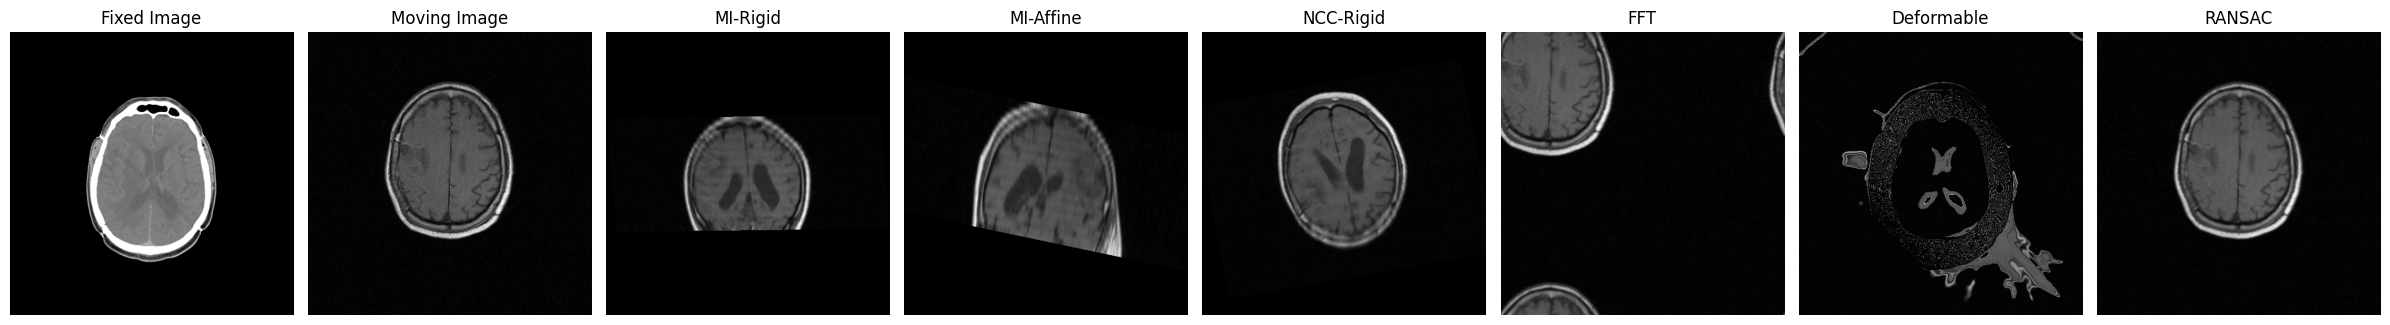

🔍 Processing patient 07
--- FFT (up=1) ---
SSIM: 0.7937, MSE: 0.0116
--- FFT (up=5) ---
SSIM: 0.7842, MSE: 0.0116
--- FFT (up=10) ---
SSIM: 0.7869, MSE: 0.0116
--- Deformable (α=0.5) ---
SSIM: 0.5345, MSE: 0.0577
--- Deformable (α=1.0) ---
SSIM: 0.6142, MSE: 0.0392
--- Deformable (α=2.0) ---
SSIM: 0.5815, MSE: 0.0415
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.7641, MSE: 0.0142
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.7641, MSE: 0.0142
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.7641, MSE: 0.0142
--- MI-Rigid ---
SSIM: 0.5764, MSE: 0.0223
--- MI-Affine ---
SSIM: 0.7760, MSE: 0.0141
--- NCC-Rigid ---
SSIM: 0.6409, MSE: 0.0129
--- FFT ---
SSIM: 0.7937, MSE: 0.0116
--- Deformable ---
SSIM: 0.6142, MSE: 0.0392
--- RANSAC ---
SSIM: 0.7641, MSE: 0.0142


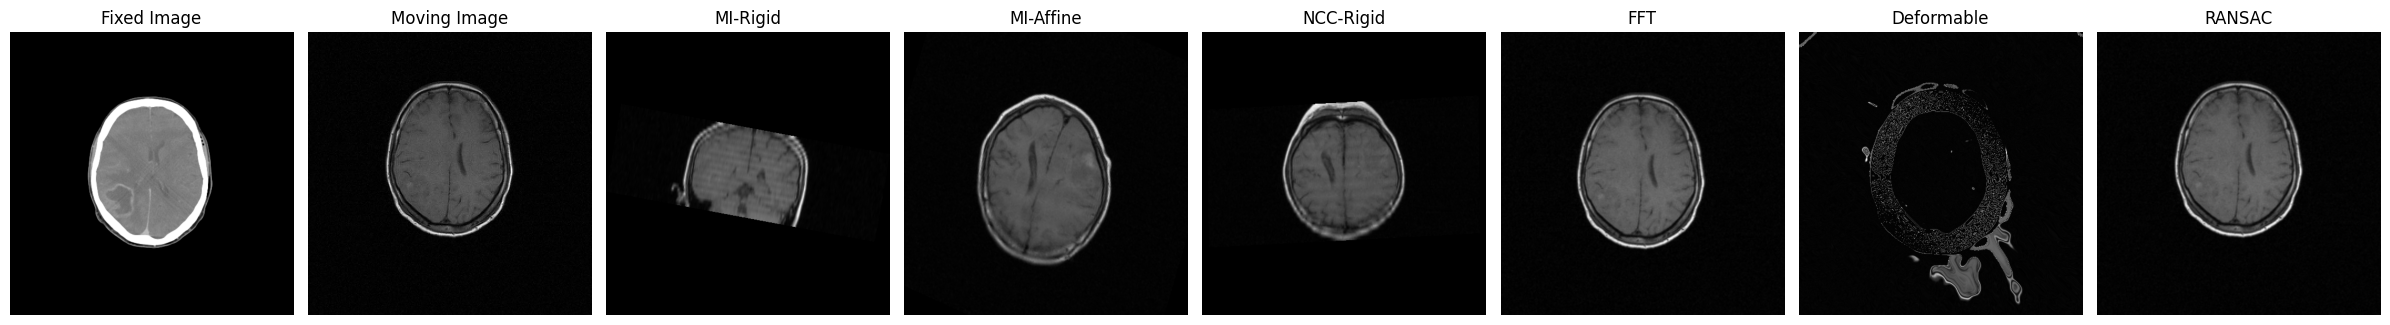

🔍 Processing patient 101
--- FFT (up=1) ---
SSIM: 0.4578, MSE: 0.0515
--- FFT (up=5) ---
SSIM: 0.4582, MSE: 0.0515
--- FFT (up=10) ---
SSIM: 0.4580, MSE: 0.0515
--- Deformable (α=0.5) ---
SSIM: 0.0629, MSE: 0.1086
--- Deformable (α=1.0) ---
SSIM: 0.1145, MSE: 0.0872
--- Deformable (α=2.0) ---
SSIM: 0.0600, MSE: 0.0885
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.4638, MSE: 0.0491
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.4638, MSE: 0.0491
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.4638, MSE: 0.0491
--- MI-Rigid ---
SSIM: 0.4717, MSE: 0.0412
--- MI-Affine ---
SSIM: 0.4393, MSE: 0.0407
--- NCC-Rigid ---
SSIM: 0.5198, MSE: 0.0393
--- FFT ---
SSIM: 0.4582, MSE: 0.0515
--- Deformable ---
SSIM: 0.1145, MSE: 0.0872
--- RANSAC ---
SSIM: 0.4638, MSE: 0.0491


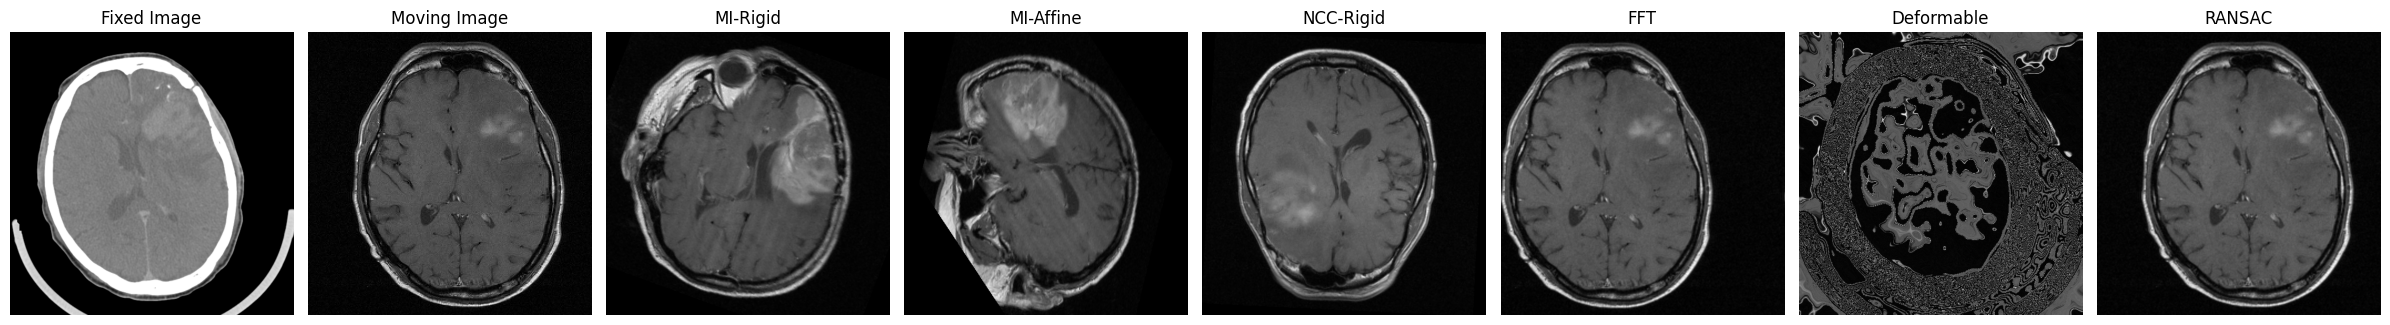

🔍 Processing patient 102
--- FFT (up=1) ---
SSIM: 0.3298, MSE: 0.0795
--- FFT (up=5) ---
SSIM: 0.3300, MSE: 0.0795
--- FFT (up=10) ---
SSIM: 0.3299, MSE: 0.0795
--- Deformable (α=0.5) ---
SSIM: 0.0511, MSE: 0.1093
--- Deformable (α=1.0) ---
SSIM: 0.0959, MSE: 0.0995
--- Deformable (α=2.0) ---
SSIM: 0.0630, MSE: 0.0924
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.4937, MSE: 0.0465
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.4937, MSE: 0.0465
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.4937, MSE: 0.0465
--- MI-Rigid ---
SSIM: 0.5146, MSE: 0.0419
--- MI-Affine ---
SSIM: 0.4867, MSE: 0.0384
--- NCC-Rigid ---
SSIM: 0.5103, MSE: 0.0389
--- FFT ---
SSIM: 0.3300, MSE: 0.0795
--- Deformable ---
SSIM: 0.0959, MSE: 0.0995
--- RANSAC ---
SSIM: 0.4937, MSE: 0.0465


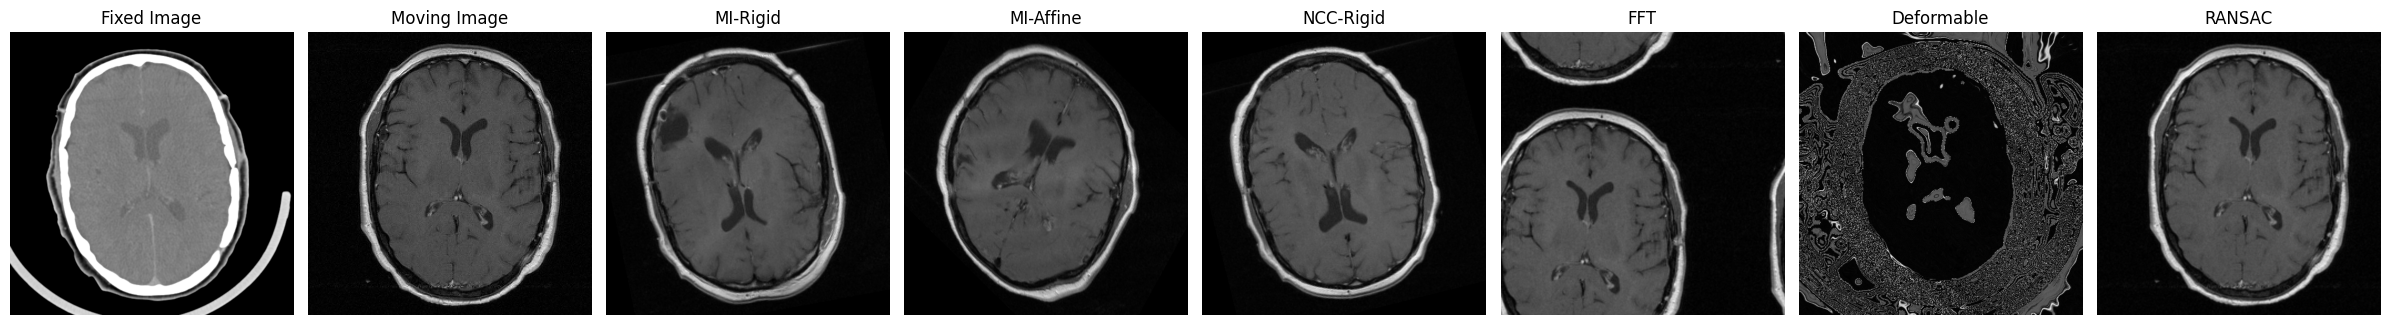

🔍 Processing patient 103
--- FFT (up=1) ---
SSIM: 0.3762, MSE: 0.0604
--- FFT (up=5) ---
SSIM: 0.3762, MSE: 0.0604
--- FFT (up=10) ---
SSIM: 0.3762, MSE: 0.0604
--- Deformable (α=0.5) ---
SSIM: 0.0797, MSE: 0.0952
--- Deformable (α=1.0) ---
SSIM: 0.1280, MSE: 0.0784
--- Deformable (α=2.0) ---
SSIM: 0.0853, MSE: 0.0736
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.5480, MSE: 0.0286
--- RANSAC (kp=250) ---
SSIM: 0.4861, MSE: 0.0366
--- RANSAC (kp=500) ---
SSIM: 0.4861, MSE: 0.0366
--- MI-Rigid ---
SSIM: 0.5231, MSE: 0.0314
--- MI-Affine ---
SSIM: 0.5565, MSE: 0.0260
--- NCC-Rigid ---
SSIM: 0.5279, MSE: 0.0291
--- FFT ---
SSIM: 0.3762, MSE: 0.0604
--- Deformable ---
SSIM: 0.1280, MSE: 0.0784
--- RANSAC ---
SSIM: 0.5480, MSE: 0.0286


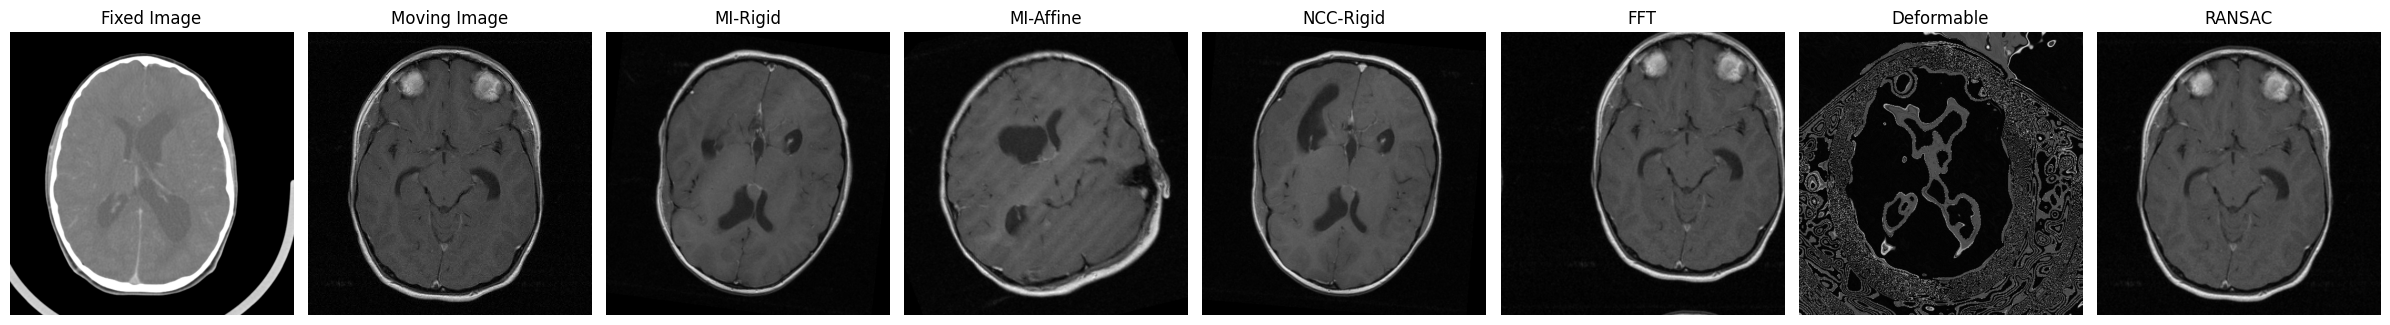

🔍 Processing patient 104
--- FFT (up=1) ---
SSIM: 0.5561, MSE: 0.0429
--- FFT (up=5) ---
SSIM: 0.5563, MSE: 0.0428
--- FFT (up=10) ---
SSIM: 0.5562, MSE: 0.0428
--- Deformable (α=0.5) ---
SSIM: 0.0569, MSE: 0.0979
--- Deformable (α=1.0) ---
SSIM: 0.1646, MSE: 0.0815
--- Deformable (α=2.0) ---
SSIM: 0.1247, MSE: 0.0784
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.5259, MSE: 0.0432
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.5259, MSE: 0.0432
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.5259, MSE: 0.0432
--- MI-Rigid ---
SSIM: 0.5183, MSE: 0.0387
--- MI-Affine ---
SSIM: 0.5187, MSE: 0.0309
--- NCC-Rigid ---
SSIM: 0.5200, MSE: 0.0379
--- FFT ---
SSIM: 0.5563, MSE: 0.0428
--- Deformable ---
SSIM: 0.1646, MSE: 0.0815
--- RANSAC ---
SSIM: 0.5259, MSE: 0.0432


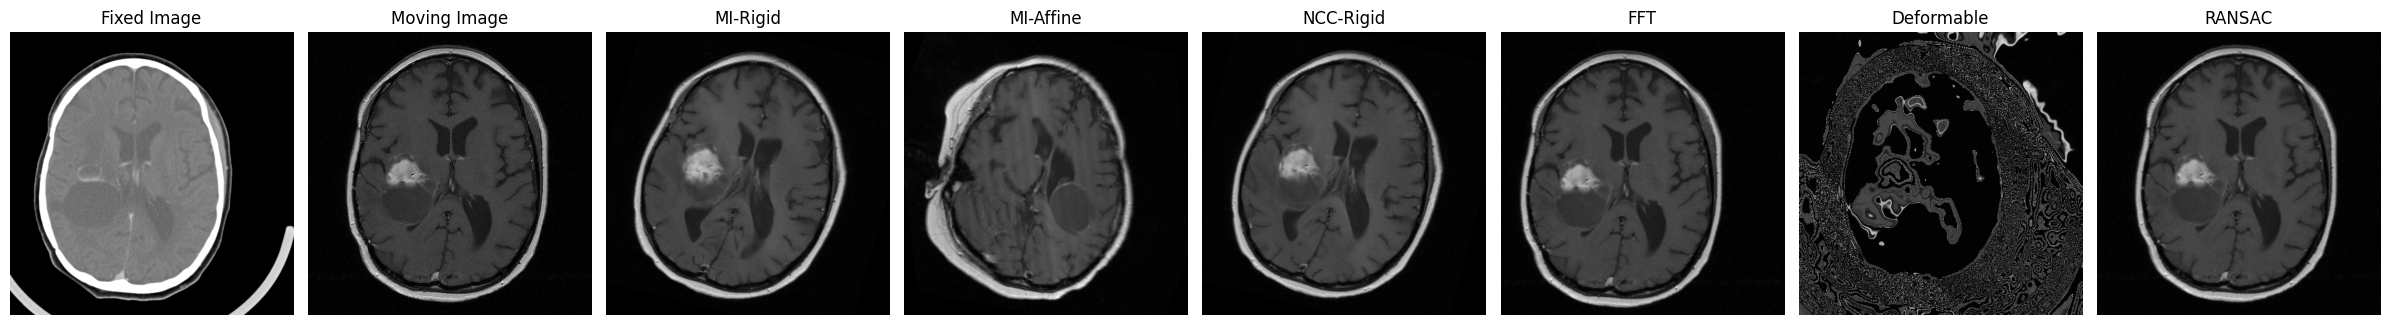

🔍 Processing patient 105
--- FFT (up=1) ---
SSIM: 0.2534, MSE: 0.0816
--- FFT (up=5) ---
SSIM: 0.2534, MSE: 0.0816
--- FFT (up=10) ---
SSIM: 0.2534, MSE: 0.0816
--- Deformable (α=0.5) ---
SSIM: 0.0519, MSE: 0.1045
--- Deformable (α=1.0) ---
SSIM: 0.1012, MSE: 0.0876
--- Deformable (α=2.0) ---
SSIM: 0.0456, MSE: 0.0975
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.4095, MSE: 0.0508
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.4095, MSE: 0.0508
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.4095, MSE: 0.0508
--- MI-Rigid ---
SSIM: 0.4670, MSE: 0.0397
--- MI-Affine ---
SSIM: 0.4710, MSE: 0.0350
--- NCC-Rigid ---
SSIM: 0.4368, MSE: 0.0400
--- FFT ---
SSIM: 0.2534, MSE: 0.0816
--- Deformable ---
SSIM: 0.1012, MSE: 0.0876
--- RANSAC ---
SSIM: 0.4095, MSE: 0.0508


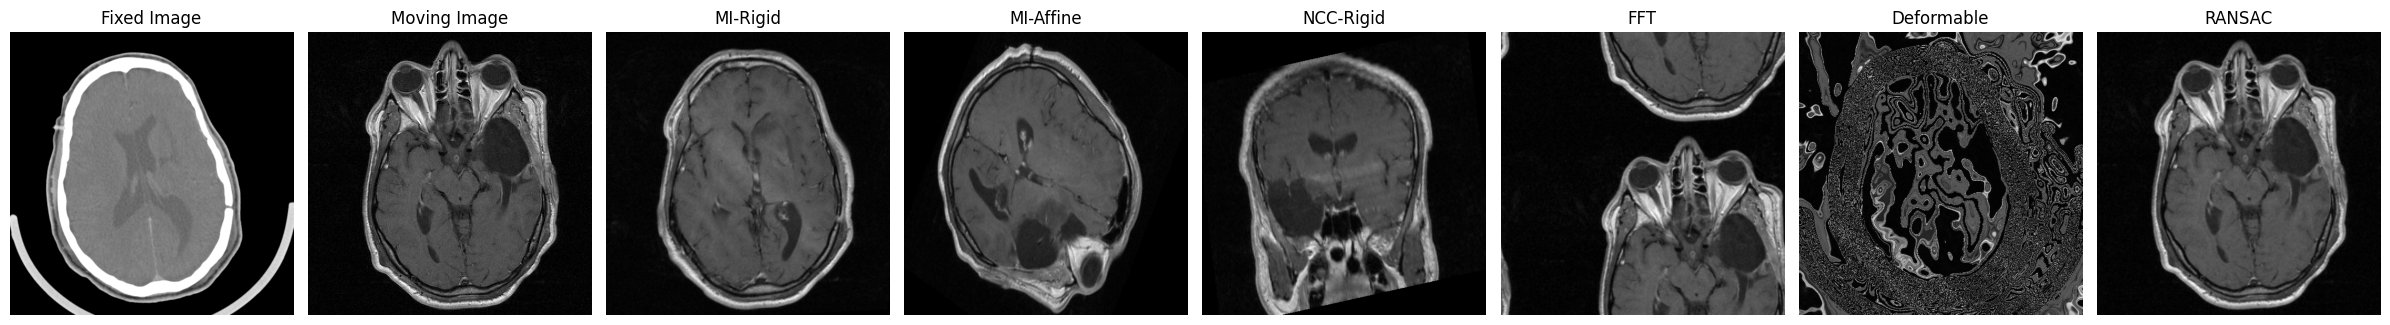

🔍 Processing patient 107
--- FFT (up=1) ---
SSIM: 0.4342, MSE: 0.0452
--- FFT (up=5) ---
SSIM: 0.4344, MSE: 0.0452
--- FFT (up=10) ---
SSIM: 0.4343, MSE: 0.0453
--- Deformable (α=0.5) ---
SSIM: 0.0653, MSE: 0.0985
--- Deformable (α=1.0) ---
SSIM: 0.1228, MSE: 0.0791
--- Deformable (α=2.0) ---
SSIM: 0.0562, MSE: 0.0885
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.4490, MSE: 0.0426
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.4490, MSE: 0.0426
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.4490, MSE: 0.0426
--- MI-Rigid ---
SSIM: 0.4445, MSE: 0.0397
--- MI-Affine ---
SSIM: 0.4406, MSE: 0.0413
--- NCC-Rigid ---
SSIM: 0.4635, MSE: 0.0384
--- FFT ---
SSIM: 0.4344, MSE: 0.0452
--- Deformable ---
SSIM: 0.1228, MSE: 0.0791
--- RANSAC ---
SSIM: 0.4490, MSE: 0.0426


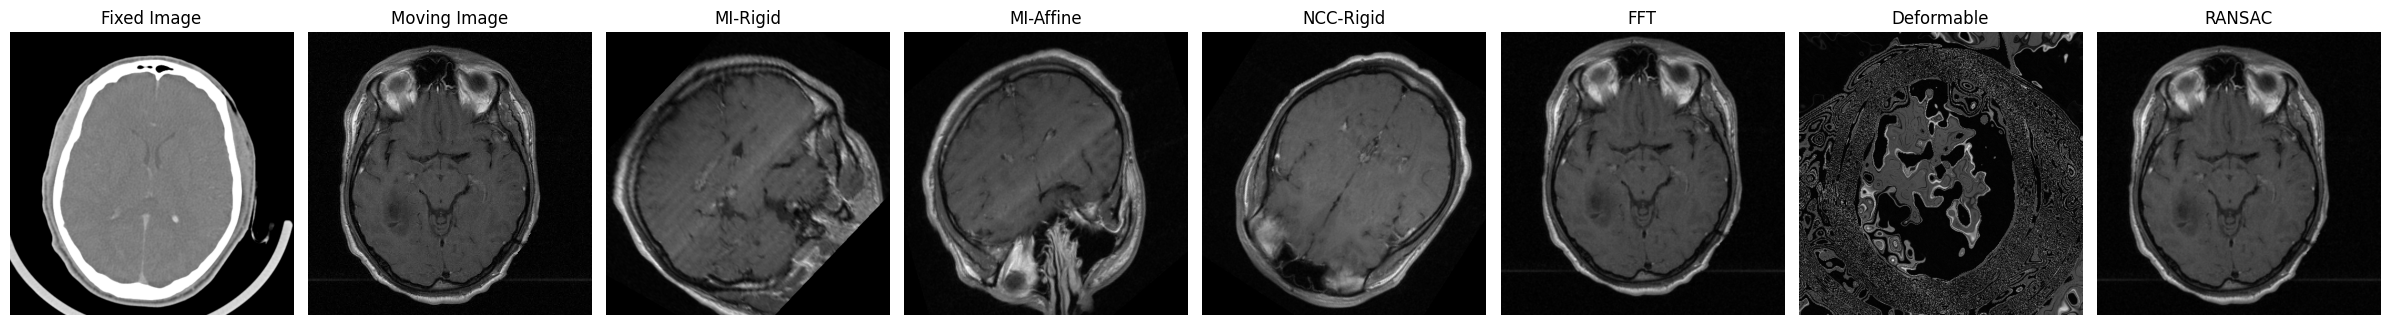

🔍 Processing patient 108
--- FFT (up=1) ---
SSIM: 0.2770, MSE: 0.0764
--- FFT (up=5) ---
SSIM: 0.2770, MSE: 0.0764
--- FFT (up=10) ---
SSIM: 0.2770, MSE: 0.0764
--- Deformable (α=0.5) ---
SSIM: 0.0485, MSE: 0.1054
--- Deformable (α=1.0) ---
SSIM: 0.1269, MSE: 0.0832
--- Deformable (α=2.0) ---
SSIM: 0.1027, MSE: 0.0824
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.4668, MSE: 0.0417
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.4668, MSE: 0.0417
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.4668, MSE: 0.0417
--- MI-Rigid ---
SSIM: 0.4149, MSE: 0.0489
--- MI-Affine ---
SSIM: 0.4484, MSE: 0.0442
--- NCC-Rigid ---
SSIM: 0.5164, MSE: 0.0339
--- FFT ---
SSIM: 0.2770, MSE: 0.0764
--- Deformable ---
SSIM: 0.1269, MSE: 0.0832
--- RANSAC ---
SSIM: 0.4668, MSE: 0.0417


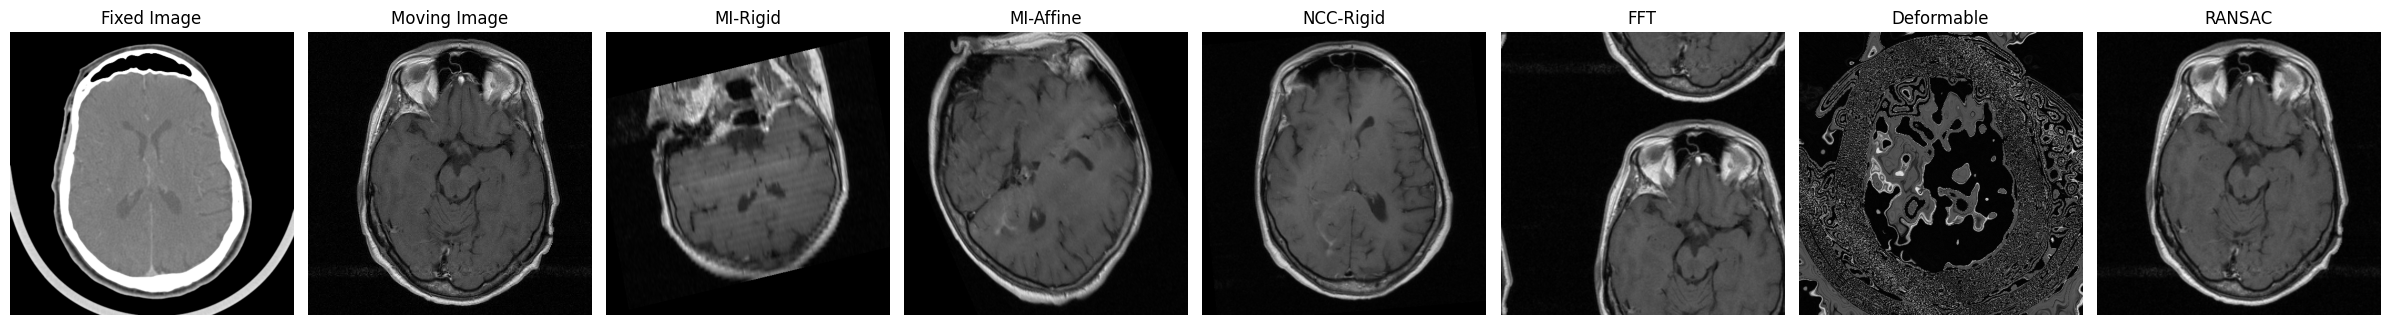

🔍 Processing patient 109
--- FFT (up=1) ---
SSIM: 0.2953, MSE: 0.0838
--- FFT (up=5) ---
SSIM: 0.2958, MSE: 0.0838
--- FFT (up=10) ---
SSIM: 0.2956, MSE: 0.0838
--- Deformable (α=0.5) ---
SSIM: 0.0516, MSE: 0.1059
--- Deformable (α=1.0) ---
SSIM: 0.1017, MSE: 0.0889
--- Deformable (α=2.0) ---
SSIM: 0.0736, MSE: 0.0908
⚠️ Not enough good matches.
--- RANSAC (kp=100) ---
SSIM: 0.4331, MSE: 0.0564
⚠️ Not enough good matches.
--- RANSAC (kp=250) ---
SSIM: 0.4331, MSE: 0.0564
⚠️ Not enough good matches.
--- RANSAC (kp=500) ---
SSIM: 0.4331, MSE: 0.0564
--- MI-Rigid ---
SSIM: 0.4527, MSE: 0.0507
--- MI-Affine ---
SSIM: 0.5132, MSE: 0.0410
--- NCC-Rigid ---
SSIM: 0.3847, MSE: 0.0452
--- FFT ---
SSIM: 0.2958, MSE: 0.0838
--- Deformable ---
SSIM: 0.1017, MSE: 0.0889
--- RANSAC ---
SSIM: 0.4331, MSE: 0.0564


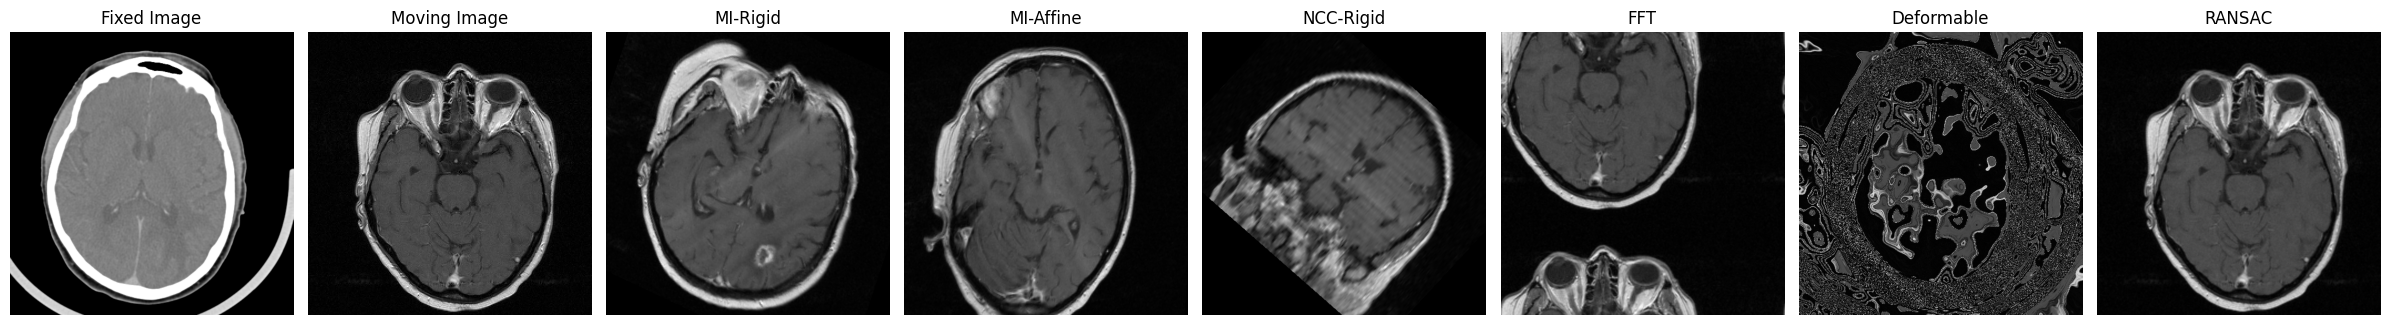

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Data/rire" # replace with /dataset/rire/
RESULTS_DIR = "/content/results"
os.makedirs(os.path.join(RESULTS_DIR, "visuals"), exist_ok=True)

all_metrics = {}

for patient_folder in sorted(os.listdir(BASE_DIR)):
    if not patient_folder.isdigit():
        continue  # skip non-patient folders like "ct", "mr_T1"

    print(f"🔍 Processing patient {patient_folder}")
    metrics = process_patient(patient_folder, BASE_DIR, RESULTS_DIR)
    if metrics:
        all_metrics[patient_folder] = metrics


In [ ]:
df = pd.DataFrame(all_metrics).T  # transpose so rows = patients
df.to_csv(os.path.join(RESULTS_DIR, "summary_metrics.csv"))
print(df)


     MI-Rigid.ssim  MI-Rigid.mse  MI-Affine.ssim  MI-Affine.mse  \
02        0.567018      0.021569        0.543188       0.024965   
03        0.620977      0.017057        0.617426       0.012690   
04        0.617918      0.014646        0.528180       0.022364   
05        0.579119      0.023735        0.720658       0.016405   
06        0.580092      0.019429        0.601996       0.018965   
07        0.576417      0.022276        0.776043       0.014147   
101       0.471716      0.041188        0.439298       0.040731   
102       0.514598      0.041913        0.486666       0.038413   
103       0.523051      0.031417        0.556548       0.025976   
104       0.518317      0.038721        0.518699       0.030950   
105       0.466993      0.039682        0.471003       0.034964   
107       0.444525      0.039687        0.440612       0.041304   
108       0.414882      0.048917        0.448396       0.044216   
109       0.452740      0.050689        0.513178       0.04097

In [ ]:
!zip -r /content/classical_results.zip /content/results > /dev/null
from google.colab import files
files.download('/content/classical_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>